In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.tensorboard import SummaryWriter

import sklearn

import dataset_class_gsimage
import torch_net_class
import utils

import functools
import operator

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [3]:
"""
Load Data
"""
mnist_image_folder = "../mnist_cnn/mnist/"
mnist_image_names = os.listdir(mnist_image_folder)
mnist_image_paths = glob.glob(mnist_image_folder + "*")
image_size = [1,28,28]
label_path_csv = "mnist_labels.csv"
dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv)
dataset.label_df.head()
target_attributes = ["number"]
output_attributes = [str(i) for i in range(0,10)]
pred_attributes = [str(i) for i in range(np.prod(image_size))]
#dataset.set_label_names(target_attributes)
dataset.label_names = target_attributes

[3.]


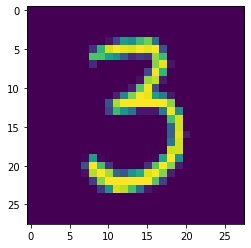

In [4]:
plt.imshow(dataset.get_image(50)[0].reshape([28,28]))
print(dataset.get_image(50)[1])

In [5]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

val_epochs = [10,20,30]
save_state_epochs = [10000]


"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

fixed_net_struct = []
image_size = dataset.get_image_size()
input_size = image_size
target_size = len(target_attributes)
#output_size = target_size
output_size = len(output_attributes)

#[ [[in_channels, out_channels],[kernel_size], ...]
kernel_pars = [ [[input_size[0],32],[3,3],1,0], [[32,32],[2,2],2,0], [[32,64],[4,4],1,0], [[64,64],[2,2],2,0] ]
act_func = torch.relu

for i, kernel_par in enumerate(kernel_pars):
    if i%2 == 0:
        layer_type = nn.Conv2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}, "act_func": act_func} )
    else:
        layer_type = nn.MaxPool2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3]}} )
    
conv_sizes = utils.calc_layer_sizes(input_size, fixed_net_struct)
fc_input_size = np.product(conv_sizes[-1])
fixed_net_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )    
#fixed_net_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": [-1,fc_input_size]}} )    
fixed_net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size}, "bias": True, "act_func": act_func} )
fixed_net_struct.append( {"type": nn.BatchNorm1d, "layer_pars": {"num_features": fc_input_size}} )
fixed_net_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.25 }} )
fixed_net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size}, "bias": True, "act_func": act_func} )
fixed_net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": output_size}, "bias": True, "act_func": act_func} )
fixed_net_struct.append( {"type": nn.Softmax, "layer_pars": {"dim": 1}} )
#dim 0 or 1???
#fixed_net_struct.append( {"type": nn.ConvTranspose2d, "layer_pars": {"in_channels": 1, "out_channels": 1, "kernel_size": [1,1], "stride": 1, "padding": 1, "bias": True}, "act_func": act_func} )

layer_sizes = utils.calc_layer_sizes(input_size, fixed_net_struct)
print(layer_sizes)

"""create list of parameters manually"""

hyper_parameters = {}
hyper_parameters["loss_func"] = nn.CrossEntropyLoss
hyper_parameters["optimizer"] = optim.Adam
hyper_parameters["batch_size"] = 10 
hyper_parameters["lr"] = 0.0001
hyper_parameters["net_struct"] = fixed_net_struct

hyper_parameters["val_method"] = "holdout"
hyper_parameters["val_method_pars"] = {"train" : 0.9, "val" : 0.1, "test" : 0.}
#hyper_parameters["val_method"] = "k_fold"
#hyper_parameters["val_method_pars"] = 5

0
[1, 28, 28]
[3, 3]
1
[32, 26, 26]
[2, 2]
2
[32, 13, 13]
[4, 4]
3
[64, 10, 10]
[2, 2]
0
[1, 28, 28]
[3, 3]
1
[32, 26, 26]
[2, 2]
2
[32, 13, 13]
[4, 4]
3
[64, 10, 10]
[2, 2]
4
[64, 5, 5]
5
1600
6
1600
7
1600
8
1600
9
1600
10
10
[[1, 28, 28], [32, 26, 26], [32, 13, 13], [64, 10, 10], [64, 5, 5], 1600, 1600, 1600, 1600, 1600, 10, 10]


In [6]:
epochs = max(val_epochs)+1

lr=hyper_parameters["lr"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"]()
net_struct = hyper_parameters["net_struct"]
val_method = hyper_parameters["val_method"]
val_method_pars = hyper_parameters["val_method_pars"]
optimizer_type = hyper_parameters["optimizer"]

val_pred_paths = []
val_label_paths = []

train_loss = np.zeros(epochs)
val_loss = np.zeros(len(val_epochs))

net_state_paths = []

#create training log
log_file_name = "log.txt"
log_file = open(log_file_name, "w")

In [7]:
tb = SummaryWriter()

net = torch_net_class.Net(net_struct, dataset.get_image_size())    
net.init_weights(torch.nn.init.xavier_normal_)
net.set_batch_size(batch_size)
#net.set_layer_sizes(layer_sizes)
net.to(device)
#net.show_layers()
net_parameters = net.parameters()

optimizer = optimizer_type(net_parameters, lr=lr)

"""SPECIFY OUTSIDE FOR K-FOLD VALIDATION"""
data_loader = utils.load_split_data(dataset=dataset, batch_size=batch_size, method=val_method, method_pars=val_method_pars, random_seed=random_seed, log_file=log_file)

if val_method == "holdout":
    data_loader = data_loader[0]
    test_loader = data_loader[2]
val_loader = data_loader[1]
train_loader = data_loader[0]

val_dir = "val/"
try:
    os.makedirs(val_dir)
except FileExistsError:
    pass
train_state_dir = "net_states/"
try:
    os.makedirs(train_state_dir)
except FileExistsError:
    pass

epoch = 0
val_i = 0
for epoch in range(epochs):
    
    batch_nr = 0
    epoch_loss = np.zeros(len(train_loader))
    
    """Actual training step"""
    for train_mini_batch in train_loader:
        batch_loss, train_output = utils.step(net, train_mini_batch, output_size, loss_func, optimizer, device, mode="train", log_file=log_file)
        epoch_loss[batch_nr] = batch_loss.item()
        batch_nr += 1
    mean_epoch_loss = epoch_loss.mean()
    train_loss[epoch] = mean_epoch_loss
    print(f"mean epoch {epoch} train loss: {mean_epoch_loss}\n")
    
    
    """save the neural networks state"""
    if epoch in save_state_epochs:
        train_state_epoch_file_path = train_state_dir + f"state_epoch_{epoch}"
        train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
        torch.save(train_state, train_state_epoch_file_path)
        net_state_paths.append(train_state_epoch_file_path)
        print(f"saved model from epoch {epoch}")
        
    """
    Validation
    """
    if epoch in val_epochs:
        val_label = []
        val_pred = []
        
        val_batch_nr = 0
        val_epoch_loss = np.zeros(len(val_loader))
        
        for val_mini_batch in val_loader:
            label_batch = val_mini_batch[1]
            val_label.append(label_batch.detach().cpu().numpy())
            val_batch_loss, val_output = utils.step(net, val_mini_batch, output_size, loss_func, optimizer, device, mode="val", log_file=log_file)
            val_epoch_loss[val_batch_nr] = val_batch_loss.item()
            #val_pred.append(val_output.detach().cpu().numpy())
            class_batch_pred = []
            #print(val_output)
            for val in val_output:
                class_index = val.argmax().detach().cpu()
                class_batch_pred.append(class_index)
            #print(class_batch_pred)
            val_pred.append(class_batch_pred)
            val_batch_nr += 1
            
        mean_val_epoch_loss = val_epoch_loss.mean()
        val_loss[val_i] = mean_val_epoch_loss
        print(f"mean epoch {epoch} val loss: {mean_val_epoch_loss}\n")
        
        val_i += 1
        
        val_pred_path = val_dir + "/" + f"val_epoch_{epoch}_pred"
        val_label_path = val_dir + "/" + f"val_epoch_{epoch}_labels"
        #print(np.array(functools.reduce(operator.iconcat, val_pred, [])))
        np.array(functools.reduce(operator.iconcat, val_pred, [])).tofile(val_pred_path, sep=" ")
        np.array(functools.reduce(operator.iconcat, val_label, [])).tofile(val_label_path, sep=" ")
        #np.array(val_pred).tofile(val_pred_path)
        #np.array(val_label).tofile(val_pred_label)
        
        val_pred_paths.append(val_pred_path)
        val_label_paths.append(val_label_path)
        
log_file.close()

Adding {'type': <class 'torch.nn.modules.conv.Conv2d'>, 'layer_pars': {'in_channels': 1, 'out_channels': 32, 'kernel_size': [3, 3], 'stride': 1, 'padding': 0, 'bias': True}, 'act_func': <built-in method relu of type object at 0x7fdd9ef7abe0>}

Adding {'type': <class 'torch.nn.modules.pooling.MaxPool2d'>, 'layer_pars': {'kernel_size': [2, 2], 'stride': 2, 'padding': 0}}

Adding {'type': <class 'torch.nn.modules.conv.Conv2d'>, 'layer_pars': {'in_channels': 32, 'out_channels': 64, 'kernel_size': [4, 4], 'stride': 1, 'padding': 0, 'bias': True}, 'act_func': <built-in method relu of type object at 0x7fdd9ef7abe0>}

Adding {'type': <class 'torch.nn.modules.pooling.MaxPool2d'>, 'layer_pars': {'kernel_size': [2, 2], 'stride': 2, 'padding': 0}}

Adding {'type': <class 'torch.nn.modules.flatten.Flatten'>, 'layer_pars': {'start_dim': 1}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 1600, 'out_features': 1600}, 'bias': True, 'act_func': <built-in method 

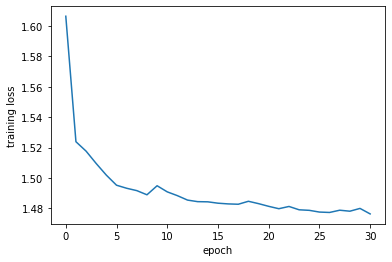

In [8]:
"""Plot training loss curve and save as image"""
train_loss_img_file_name = "train_loss.png"
x_epochs = range(epochs)
plt.plot(x_epochs, train_loss)
#plt.title()
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.savefig(train_loss_img_file_name)
plt.show()
plt.close()
train_loss_txt_file_name = "train_loss.txt"
np.savetxt(train_loss_txt_file_name, train_loss)

In [9]:
val_labels = np.fromfile(val_label_paths[-1], sep=" ")
val_pred = np.fromfile(val_pred_paths[-1], sep=" ")

In [10]:
val_labels

array([4., 4., 1., ..., 8., 9., 4.])

In [11]:
val_pred

array([4., 4., 7., ..., 8., 9., 4.])

In [12]:
conf_mat = sklearn.metrics.confusion_matrix(val_labels,val_pred)
conf_mat

array([[114,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 110,   3,   0,   0,   1,   0,   1,   0,   2],
       [  0,   1,  93,   2,   0,   0,   3,   2,   3,   1],
       [  0,   0,   3, 107,   0,   0,   0,   2,   0,   0],
       [  0,   3,   0,   0, 108,   0,   1,   2,   0,   2],
       [  1,   2,   1,   9,   0,  96,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0, 130,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 107,   3,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  90,   1],
       [  1,   0,   0,   2,   1,   0,   0,   0,   2, 101]])

In [13]:
norm_conf_mat = conf_mat/conf_mat.sum(axis=1)
norm_conf_mat

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.94017094, 0.02857143, 0.        , 0.        ,
        0.00917431, 0.        , 0.00909091, 0.        , 0.01869159],
       [0.        , 0.00854701, 0.88571429, 0.01785714, 0.        ,
        0.        , 0.02290076, 0.01818182, 0.03296703, 0.00934579],
       [0.        , 0.        , 0.02857143, 0.95535714, 0.        ,
        0.        , 0.        , 0.01818182, 0.        , 0.        ],
       [0.        , 0.02564103, 0.        , 0.        , 0.93103448,
        0.        , 0.00763359, 0.01818182, 0.        , 0.01869159],
       [0.00877193, 0.01709402, 0.00952381, 0.08035714, 0.        ,
        0.88073394, 0.        , 0.        , 0.        , 0.        ],
       [0.00877193, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99236641, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

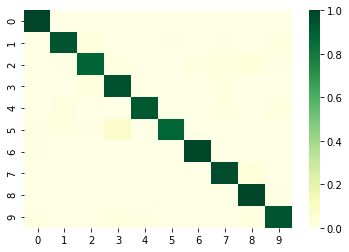

In [14]:
sns.heatmap(norm_conf_mat,cmap="YlGn")

In [15]:
acc = sklearn.metrics.accuracy_score(val_labels, val_pred)
rec = sklearn.metrics.recall_score(val_labels, val_pred, average=None)
prec = sklearn.metrics.precision_score(val_labels, val_pred, average=None)

print("Accuracy:\n {}".format(acc))

print("Recall:\n {}".format(rec))
print("averaged recall: {} +- {}".format(rec.mean(), rec.std()) )

print("Precision:\n {}".format(prec))
print("averaged precision: {} +- {}".format(prec.mean(), prec.std()) )

Accuracy:
 0.9496402877697842
Recall:
 [1.         0.94017094 0.88571429 0.95535714 0.93103448 0.88073394
 0.99236641 0.97272727 0.98901099 0.94392523]
averaged recall: 0.9491040704051981 +- 0.03972104561157897
Precision:
 [0.97435897 0.94827586 0.93       0.89166667 0.99082569 0.98969072
 0.97014925 0.93859649 0.91836735 0.94392523]
averaged precision: 0.9495856238360535 +- 0.030352995142287925
